## Import dependencies

In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import signal
from scipy.io.idl import readsav
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import io
import cmocean
from bs4 import BeautifulSoup
import urllib.request
from io import StringIO, BytesIO
from zipfile import ZipFile
import tqdm
import seaborn as sn
import re

## get SSP emissions
from tools.RCMIP import *

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

%load_ext line_profiler
%load_ext memory_profiler

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
../tools/RCMIP.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  GIR_to_RCMIP_map.loc[RCMIP_to_GIR_map_concs.values(),'RCMIP_concs_unit'] = RCMIP_concs.loc[('World','ssp245')].reindex(RCMIP_to_GIR_map_concs.keys()).loc[:,'Unit'].values#.loc[('World','ssp245',RCMIP_to_GIR_map_concs.keys()),'Unit'].values


## Contents:
- SSP inverse emissions (CO2 CH4 N2O)
- SSP concentrations (CO2 CH4 N2O)
- SSP forcings
- SSP temperature plumes
- Comparison of C4MIP / FaIR carbon cycle feedback parameters?

### Supplementary figures
- comparison of the FaIR and GIR carbon cycle
- Etminan comparison (OLBL vs Etminan formulae)
- comparing the CH4 lifetime computation with Holmes
- 1pctCO2 / abrupt4xCO2, compare to CMIP6
- compare SSPs to CMIP6?

# NROY Ensemble Generation

## Part I: the Global Warming Index

In [2]:
## Import data
baseline = ['1861','1880']

url = "https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.monthly_ns_avg.txt"
req = requests.get(url, headers=header)
data = StringIO(req.text)
HadCRUT4 = pd.read_csv(data,delim_whitespace=True,index_col=0,names=['date','anom','lower_bias','upper_bias','lower_measure','upper_measure','lower_cover','upper_cover','lower_bias_measure','upper_bias_measure','lower_full','upper_full']).apply(pd.to_numeric)
HadCRUT4.index = pd.to_datetime(['-'.join(x.split('/'))+'-01' for x in HadCRUT4.index])
HadCRUT4 = HadCRUT4['anom'].rename('HadCRUT4')

GISS = pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.txt",skiprows=7,skipfooter=7,delim_whitespace=True,index_col=0).iloc[:,:12]
GISS = GISS.loc[GISS.index!='Year'].replace('****',np.nan).apply(pd.to_numeric)/100
month_map = dict(zip(GISS.columns,["{:02d}".format(x) for x in np.arange(1,13)]))
GISS = pd.DataFrame(GISS.values.flatten(),index = pd.to_datetime([x+'-'+month_map[y]+'-01' for x in GISS.index for y in GISS.columns]),columns=['anom'])
GISS = GISS['anom'].rename('GISTEMP')

CW_Had4_krig = pd.read_csv("https://www-users.york.ac.uk/~kdc3/papers/coverage2013/had4_krig_v2_0_0.txt",delim_whitespace=True,index_col=0,names=['date','anom','unc_full','unc_cover','unc_ens']).apply(pd.to_numeric)
CW_Had4_krig.index = pd.to_datetime([str(int(x//1))+'-'+"{:02d}".format(int((x % 1)*12)+1)+'-01' for x in CW_Had4_krig.index])
CW_Had4_krig = CW_Had4_krig['anom'].rename('CW')

Berkeley = pd.read_csv("http://berkeleyearth.lbl.gov/auto/Global/Land_and_Ocean_complete.txt",skiprows=76,delim_whitespace=True,usecols=[0,1,2,3],names=['date','month','anom','unc_full'])
Berkeley = Berkeley.iloc[:Berkeley.loc[Berkeley.date=='%'].index.min()].apply(pd.to_numeric)
Berkeley.index = pd.to_datetime(Berkeley.date.astype(str) + Berkeley.month.astype(str),format='%Y%m')
Berkeley = Berkeley['anom'].rename('Berkeley')

parser = 'html.parser'  # or 'lxml' (preferred) or 'html5lib', if installed
resp = urllib.request.urlopen("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/")
soup = BeautifulSoup(resp, parser, from_encoding=resp.info().get_param('charset'))
NOAA_fname = [x['href'] for x in soup.find_all('a', href=True) if x['href'].split('.')[1:5]==['mon','land_ocean','90S','90N']][0]
NOAA = pd.read_csv("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/"+NOAA_fname,delim_whitespace=True,names=['date','month','anom','unc_full'],usecols=[0,1,2,3]).apply(pd.to_numeric)
NOAA.index = pd.to_datetime(NOAA.date.astype(str) + NOAA.month.astype(str),format='%Y%m')
NOAA = NOAA['anom'].rename('NOAA')

## Combine into a single df

GMST_datasets = pd.concat([HadCRUT4,CW_Had4_krig,GISS,NOAA,Berkeley],axis=1)

## Baseline to 1861:1880 OR to HadCRUT4 20C mean if data begins in 1880 (GISTEMP / NOAA)

GMST_datasets.loc[:,['HadCRUT4','CW','Berkeley']] -= GMST_datasets.loc[baseline[0]:baseline[1],['HadCRUT4','CW','Berkeley']].mean()
GMST_datasets.loc[:,['GISTEMP','NOAA']] -= GMST_datasets.loc['1900':'2000',['GISTEMP','NOAA']].mean() -  GMST_datasets.loc['1900':'2000','HadCRUT4'].mean()

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


<AxesSubplot:>

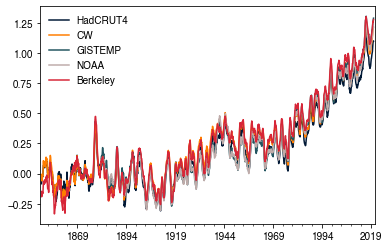

In [3]:
GMST_datasets.rolling(12).mean().plot()

In [4]:
## Import the observational uncertainty from HadCRUT

HadCRUT_ensmem_zip = ZipFile(BytesIO(requests.get('https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.annual_ns_avg_realisations.zip').content))
HadCRUT_ensmem_fnames = [x.filename for x in HadCRUT_ensmem_zip.infolist() if x.filename[-4:] == '.txt']
HadCRUT_ensmem_index = pd.read_csv(HadCRUT_ensmem_zip.open(HadCRUT_ensmem_fnames[0]),header=None,delim_whitespace=True,usecols=[0],index_col=0).index
# HadCRUT_ensmem_index = pd.to_datetime(['-'.join(x.split('/'))+'-01' for x in HadCRUT_ensmem_index])
HadCRUT_ensmem = pd.concat([pd.read_csv(HadCRUT_ensmem_zip.open(x),header=None,delim_whitespace=True,usecols=[1]).iloc[:,0].rename(str(i)) for i,x in enumerate(HadCRUT_ensmem_fnames)],axis=1)
HadCRUT_ensmem.index = HadCRUT_ensmem_index

In [5]:
## import forcing ensemble: for now, use the most up-to-date copy I have (.idlsave)

# forcing_dataset = readsav('/home/leachl/Documents/Datasets/RF/1750_Oct2017_forcings.idlsave')
# rf_ant = pd.DataFrame(forcing_dataset['rf_anthro'].byteswap().newbyteorder(),index = pd.to_datetime([str(int(x))+'-01-01' for x in forcing_dataset['year']])).apply(pd.to_numeric)
# rf_nat = pd.DataFrame(forcing_dataset['rf_nat'].byteswap().newbyteorder(),index = pd.to_datetime([str(int(x))+'-01-01' for x in forcing_dataset['year']])).apply(pd.to_numeric)

In [17]:
## creating a forcing response dataset

erf_ar6 = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_ssp245_1750-2500.csv',index_col=0,dtype=float)
erf_ar6 -= erf_ar6.loc[1750]

aer_ar6 = pd.read_csv('../tmp/aerosol_forcing.csv',index_col=0)

In [7]:
## generating many rf shapes for the GWI

N = 10000

rf_factors = {}

rf_factors['co2'] = sp.stats.norm(1,0.20/1.645).rvs(N)#ppf((erf_ar6.mean()>0).co2*random_percentiles + ~(erf_ar6.mean()>0).co2*(1-random_percentiles))
rf_factors['ch4'] = sp.stats.norm(1,0.28/1.645).rvs(N)#ppf((erf_ar6.mean()>0).ch4*random_percentiles + ~(erf_ar6.mean()>0).ch4*(1-random_percentiles))
rf_factors['n2o'] = sp.stats.norm(1,0.2/1.645).rvs(N)#ppf((erf_ar6.mean()>0).n2o*random_percentiles + ~(erf_ar6.mean()>0).n2o*(1-random_percentiles))
rf_factors['other_wmghg'] = sp.stats.norm(1,0.20/1.645).rvs(N)#ppf((erf_ar6.mean()>0).other_wmghg*random_percentiles + ~(erf_ar6.mean()>0).other_wmghg*(1-random_percentiles))
rf_factors['o3_tropospheric'] = sp.stats.norm(1,0.5/1.645).rvs(N)#ppf((erf_ar6.mean()>0).o3_tropospheric*random_percentiles + ~(erf_ar6.mean()>0).o3_tropospheric*(1-random_percentiles))
rf_factors['o3_stratospheric'] = sp.stats.norm(1,2/1.645).rvs(N)#ppf((erf_ar6.mean()>0).o3_stratospheric*random_percentiles + ~(erf_ar6.mean()>0).o3_stratospheric*(1-random_percentiles))
rf_factors['h2o_stratospheric'] = sp.stats.norm(1,0.72/1.645).rvs(N)#ppf((erf_ar6.mean()>0).h2o_stratospheric*random_percentiles + ~(erf_ar6.mean()>0).h2o_stratospheric*(1-random_percentiles))
rf_factors['contrails'] = sp.stats.norm(1,0.75/1.645).rvs(N)#ppf((erf_ar6.mean()>0).contrails*random_percentiles + ~(erf_ar6.mean()>0).contrails*(1-random_percentiles))
rf_factors['land_use'] = sp.stats.norm(1,0.75/1.645).rvs(N)#ppf((erf_ar6.mean()>0).land_use*random_percentiles + ~(erf_ar6.mean()>0).land_use*(1-random_percentiles))
rf_factors['volcanic'] = sp.stats.norm(1,0.5/1.645).rvs(N)
rf_factors['solar'] = sp.stats.norm(1,1/1.645).rvs(N)

pct_5 = 0.04
pct_95=0.18
sigma = (np.log(0.18) - np.log(0.04)) / (sp.stats.norm().ppf(0.95)-sp.stats.norm().ppf(0.05))
mu = np.log(0.04) - sigma * sp.stats.norm().ppf(0.05)
rf_factors['bc_on_snow'] = sp.stats.lognorm(s=sigma,scale=np.exp(mu)).rvs(N)

ant_rf_ensemble = np.zeros((270,N))
nat_rf_ensemble = np.zeros((270,N))

for agent in ['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','land_use','bc_on_snow']:
    ant_rf_ensemble += rf_factors[agent]*erf_ar6.loc[1750:2019,agent].values[:,None]
        
for agent in ['volcanic','solar']:
    nat_rf_ensemble += rf_factors[agent]*erf_ar6.loc[1750:2019,agent].values[:,None]
        
## aerosol distribution generation year-on-year

# random_percentiles = np.random.random(N)

# aer_std = abs((aer_ar6['pc84']-aer_ar6['mean'])/aer_ar6['mean']).rolling(20).mean()
# aer_std.loc[:1849] = aer_std.loc[1845:1849].mean()

# for i in np.arange(ant_rf_ensemble.shape[0]):
#     ant_rf_ensemble[i] += sp.stats.norm(1,aer_std.loc[i+1750]).ppf(random_percentiles) * aer_ar6.loc[i+1750,'mean']

In [8]:
## New aerosol generation methodology, following Smith et al (2020) ; multivariate gaussian distribution, sample parameters, generate shapes from emission data.
ERFari_params = pd.DataFrame(data=np.array([[ 3.25934432e-02, -3.46653116e-04, -2.48761587e-03],
       [ 2.48231885e-02, -1.26321908e-02, -9.42090973e-04],
       [ 2.68560170e-02, -2.08950151e-03, -2.60579679e-03],
       [ 1.01700746e-01, -3.04192033e-02, -2.63868473e-03],
       [ 1.46132214e-01, -4.41485999e-02, -6.67827786e-03],
       [ 1.95732170e-03,  4.15481407e-03, -2.90822562e-03],
       [-5.61261154e-02,  8.85201623e-03, -7.47602910e-04],
       [ 3.87211606e-02, -1.42408227e-02, -1.78155606e-03],
       [ 3.02173214e-03, -3.40228173e-03, -1.25702781e-03],
       [ 2.54832726e-03,  6.32322444e-05, -2.38863636e-03]]),index=['CanESM5', 'E3SM', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
       'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'NorESM2-LM',
       'UKESM1-0-LL'],columns=['bc', 'oc', 'so2'])

ERFari_sfs = sp.stats.multivariate_normal(ERFari_params.mean(),ERFari_params.cov()).rvs(N)
ERFari_samples = (ERFari_sfs[...,None]*RCMIP_emms.loc[('World','ssp245',['Emissions|BC','Emissions|OC','Emissions|Sulfur'])].droplevel((0,1)).iloc[:,4:].apply(pd.to_numeric).interpolate(axis=1).loc[:,:'2019'].values[None,...]).sum(axis=1)

### LINEAR ERFaci params
# ERFaci_params = pd.DataFrame(data=np.array([[-0.23977316,  0.05033984, -0.0026841 ],
#        [-0.03596736, -0.0061301 , -0.00999338],
#        [-0.02306089, -0.00397075, -0.00440759],
#        [-0.04100239, -0.00815999, -0.00296047],
#        [-0.11952911,  0.01185454, -0.00136009],
#        [-0.0751146 ,  0.0115965 , -0.00595064],
#        [-0.00958696,  0.00027465, -0.00252801],
#        [-0.10616509,  0.01464634, -0.00292868],
#        [ 0.02490414, -0.02261304, -0.00721553],
#        [ 0.06822656, -0.01548075, -0.01065098]])
# ,index=['CanESM5', 'E3SM', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
#        'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'NorESM2-LM',
#        'UKESM1-0-LL'],columns=['bc', 'oc', 'so2'])

### LOG so2 ERFaci params
ERFaci_params = pd.DataFrame(data=np.array([[-8.04936152e-01, -4.33765114e+00, -1.76516101e-02],
       [ 4.20348167e-01, -4.19165818e+00, -1.57827154e-02],
       [ 1.67034191e+00, -5.34562320e+00, -8.80674737e-03],
       [ 2.25088976e+00, -5.57251763e+00, -1.19361347e-02],
       [-1.80621064e+00, -4.82004944e+00, -1.88411062e-02],
       [-1.48244252e-01, -4.48450777e+00, -6.70740113e-03],
       [ 1.03705925e+00, -5.88364385e+00, -1.91422284e-03],
       [-1.00837014e+00, -4.73118298e+00, -1.30437040e-02],
       [ 2.07731610e+00, -5.03084334e+00, -1.39245898e-02],
       [-2.52178641e-01, -3.93423009e+00,  3.35367830e-03]])

,index=['CanESM5', 'E3SM', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
       'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'NorESM2-LM',
       'UKESM1-0-LL'],columns=['log_beta', 'log_beta_s', 'alpha'])

# ERFaci_params.loc[:,'so2_logcoef'] = np.log(-1*ERFaci_params.loc[:,'so2_logcoef'])

### LINEAR ERFaci params
# ERFaci_sfs = sp.stats.multivariate_normal(ERFaci_params.mean(),ERFaci_params.cov()).rvs(N)
# ERFaci_samples = (ERFaci_sfs[...,None]*RCMIP_emms.loc[('World','ssp245',['Emissions|BC','Emissions|OC','Emissions|Sulfur'])].droplevel((0,1)).iloc[:,4:].apply(pd.to_numeric).interpolate(axis=1).loc[:,:'2019'].values[None,...]).sum(axis=1)

### LOG so2 ERFaci params
beta_samples = -1 * np.exp( sp.stats.norm(ERFaci_params['log_beta'].mean(),ERFaci_params['log_beta'].std()).rvs(N) )[...,None]
beta_s_samples = np.exp( sp.stats.norm(ERFaci_params['log_beta_s'].mean(),ERFaci_params['log_beta_s'].std()).rvs(N) )[...,None]
s_samples = -1 * beta_samples / beta_s_samples
alpha_samples = sp.stats.norm(ERFaci_params['alpha'].mean(),ERFaci_params['alpha'].std()).rvs(N)[...,None]

RCMIP_so2_emms = RCMIP_emms.loc[('World','ssp245','Emissions|Sulfur')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]
RCMIP_oc_emms = RCMIP_emms.loc[('World','ssp245','Emissions|OC')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]
RCMIP_bc_emms = RCMIP_emms.loc[('World','ssp245','Emissions|BC')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]

ERFaci_samples = beta_samples * np.log(1+RCMIP_so2_emms/s_samples) + alpha_samples * ( RCMIP_oc_emms+RCMIP_bc_emms )

tot_aer = (ERFari_samples+ERFaci_samples).T
tot_aer -= tot_aer[0]

ant_rf_ensemble += tot_aer

In [9]:
rf_nat = pd.DataFrame(nat_rf_ensemble,index=np.arange(1750,2020),columns=pd.MultiIndex.from_product([['forcing_'+str(x) for x in np.arange(N)],['forcing']]))

rf_ant = pd.DataFrame(ant_rf_ensemble,index=np.arange(1750,2020),columns=pd.MultiIndex.from_product([['forcing_'+str(x) for x in np.arange(N)],['forcing']]))

<AxesSubplot:>

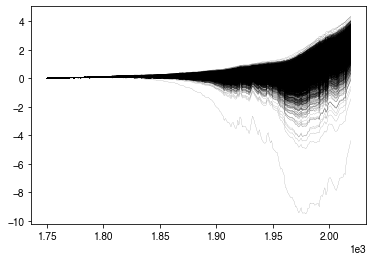

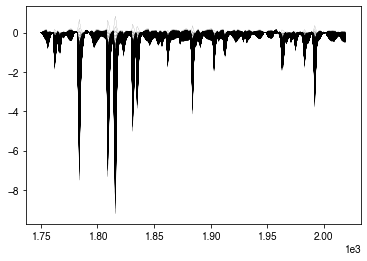

In [26]:
rf_ant.plot(legend=None,lw=0.1,c='k')

rf_nat.plot(legend=None,lw=0.1,c='k')

In [11]:
## create the response parameter ranges:

### based on inferred ranges from CMIP6
response_names = ['response_'+str(x) for x in np.arange(24)]
response_params = pd.DataFrame(index=['d','q'],columns = pd.MultiIndex.from_product([response_names,[1,2,3]])).apply(pd.to_numeric)
response_params.loc[:] = 0

d1_range = [0.2,0.8,1.4,2]
d2_range = [4,8,12,16]
d3_range = [100,200,400,800]
q1_range = [0.04,0.16,0.28,0.4]

RWF_range = [0.3 , 0.4 , 0.5, 0.6, 0.7, 0.8]
ECS=3

i=0
for d_num in np.arange(4):
    for RWF in RWF_range:
        response_params.loc['d',(response_names[i],1)] = d1_range[d_num]
        response_params.loc['d',(response_names[i],2)] = d2_range[d_num]
        response_params.loc['d',(response_names[i],3)] = d3_range[d_num]
        response_params.loc['q',(response_names[i],1)] = q1_range[d_num]

        q2,q3 = sp.optimize.root(lambda x: q_to_tcr_ecs(response_params.reindex([response_names[i]],axis=1,level=0) + [[0,0],[0,x[0]],[0,x[1]]],F_2x=3.76).values.flatten() - np.array([ECS,ECS*RWF]),x0=np.array([0.32,0.47]),method='lm').x

        response_params.loc['q',(response_names[i],2)] = q2
        response_params.loc['q',(response_names[i],3)] = q3

        i+=1
            
## remove any that are unphysical (negative parameters)

response_params = response_params.reindex([i for i,x in ((response_params<0).sum().unstack().sum(axis=1)==1).iteritems() if not x],axis=1,level=0)

In [12]:
## generate the temperature responses:

### reshape the rf dataframes into model inputs (only for old forcing data):
# rf_ant['YEAR'] = [x.year for x in rf_ant.index]
# rf_ant.set_index('YEAR',inplace=True)
# rf_ant.columns = pd.MultiIndex.from_product([['forcing_'+str(x) for x in rf_ant.columns],['forcing']])
# rf_ant = rf_ant.reindex(rf_ant.index.append(pd.Index([2018,2019])))
# rf_ant.loc[2018] = rf_ant.loc[2017]+(rf_ant.loc[2017] - rf_ant.loc[2012])/5
# rf_ant.loc[2019] = rf_ant.loc[2017]+2*(rf_ant.loc[2017] - rf_ant.loc[2012])/5

# rf_nat['YEAR'] = [x.year for x in rf_nat.index]
# rf_nat.set_index('YEAR',inplace=True)
# rf_nat.columns = pd.MultiIndex.from_product([['forcing_'+str(x) for x in rf_nat.columns],['forcing']])
# rf_nat.loc[2018] = rf_nat.loc[2017]+(rf_nat.loc[2017] - rf_nat.loc[2012])/5
# rf_nat.loc[2019] = rf_nat.loc[2017]+2*(rf_nat.loc[2017] - rf_nat.loc[2012])/5

##
temp_ant = run_GIR(emissions_in=return_empty_emissions(rf_ant),forcing_in=rf_ant,thermal_parameters=response_params)['T'].droplevel(1,axis=1)
temp_nat = run_GIR(emissions_in=return_empty_emissions(rf_nat),forcing_in=rf_nat,thermal_parameters=response_params)['T'].droplevel(1,axis=1)

Integrating 10000 scenarios, 1 gas cycle parameter sets, 18 independent thermal response parameter sets, over ['CH4', 'CO2', 'N2O'], between 1750 and 2019...


100%|██████████| 269/269 [00:16<00:00, 16.36 timestep/s]


Integrating 10000 scenarios, 1 gas cycle parameter sets, 18 independent thermal response parameter sets, over ['CH4', 'CO2', 'N2O'], between 1750 and 2019...


100%|██████████| 269/269 [00:16<00:00, 16.07 timestep/s]


/home/leachl/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3263: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

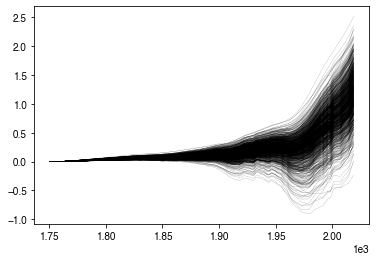

In [13]:
temp_ant.iloc[:,np.random.choice(18*N,1000)].plot(legend=False,lw=0.1,c='k')

In [14]:
## generate the temperature dataset:

temp_obs_med = GMST_datasets.mean(axis=1).loc[:'2019'].resample('Y').mean().values

temp_obs_unc = HadCRUT_ensmem.loc[:2019].values - HadCRUT_ensmem.loc[:2019].median(axis=1)[:,np.newaxis]

temp_obs_full = temp_obs_med[:,np.newaxis] + temp_obs_unc

In [15]:
# definition to compute the regressions:
def OLSE_NORM(X,Y,add_intercept=True):
    
    ## computes a multiple OLS regression over a field against several indices. First dimension is time, second is features (X), or targets (Y)
    
    if add_intercept:
    
        X_1 = np.concatenate((np.ones(X.shape[0])[:,np.newaxis],X),axis=1)
        
    else:
        
        X_1 = X.copy()
    
    B = np.dot( np.linalg.inv( np.dot( X_1.T , X_1 ) ) , np.dot( X_1.T , Y ) )
    
#     e = Y - np.dot(X_1,B)
    
#     SSE = np.sum(e**2,axis=0)

#     MSE_var = SSE / (X_1.shape[0] - X_1.shape[-1])

#     SE_B = np.sqrt( np.diag( np.linalg.inv( np.dot( X_1.T , X_1 ) ) )[:,np.newaxis] * MSE_var[np.newaxis,:] )
    return {'coefs':B[1:],'intercept':B[0]}
#     return {'coefs':B[1:],'coef_err':SE_B[1:],'res':e,'intercept':B[0],'intercept_err':SE_B[0]}

In [16]:
ant_coefs = np.empty((100,temp_ant.shape[1]))
nat_coefs = np.empty((100,temp_nat.shape[1]))

for i in tqdm.tqdm(np.arange(ant_coefs.shape[1])):
    _lreg_coefs = OLSE_NORM(np.array([temp_ant.iloc[100:,i].values,temp_nat.iloc[100:,i].values]).T,temp_obs_full)['coefs']
    ant_coefs[:,i] = _lreg_coefs[0]
    nat_coefs[:,i] = _lreg_coefs[1]
#     ant_coefs.iloc[:,i] = _lreg_coefs[0]
#     nat_coefs.iloc[:,i] = _lreg_coefs[1]

100%|██████████| 180000/180000 [04:17<00:00, 697.81it/s]


In [17]:
## computing the uncertainty from internal variability

### get internal variability timeseries:

CMIP6_int_var = pd.read_csv('../tools/cmip6_data/piControl_tas.csv',index_col=0)

### subsample 100 * 170 year slices
### check if drift, discard if drift
### randomly pick one non-drifting sample

CMIP6_int_var_samples = pd.DataFrame(index=np.arange(170))
for model,data in CMIP6_int_var.iteritems():
    arr = data.dropna().values
    chunksize = arr.size
    if chunksize<170:
        continue
    starting_points = np.random.choice(np.arange(chunksize-170),100)
    nodrift_points = []
    for s in starting_points:
        subarr = arr[s:s+170]
        drift = sp.stats.linregress(np.arange(170),subarr).slope
        if drift*100>0.15:
            continue
        else:
            nodrift_points+=[s]
    chosen_start = np.random.choice(nodrift_points)
    CMIP6_int_var_samples.loc[:,model] = arr[chosen_start:chosen_start+170] - arr[chosen_start:chosen_start+170].mean()

In [18]:
### remove model degeneracies:

int_var_models = []
for model in CMIP6_int_var_samples.columns:
    if [x.split('_')[1] for x in CMIP6_int_var_samples.columns].count(model.split('_')[1]) > 1:
        all_mems = [x for x in CMIP6_int_var_samples.columns if x.split('_')[1] == model.split('_')[1]]
        all_mems = [x.split('_')[2] for x in all_mems]
        curr_mem = model.split('_')[2]
        all_mem_nos = np.array([int(''.join(re.findall(r'\d+',mem))) for mem in all_mems])
        curr_mem_no = int(''.join(re.findall(r'\d+',curr_mem)))
        if all(curr_mem_no < all_mem_nos):
            int_var_models += [model]
            continue
    else:
        int_var_models += [model]
        
CMIP6_int_var_samples_nondeg = CMIP6_int_var_samples.loc[:,int_var_models]

<AxesSubplot:>

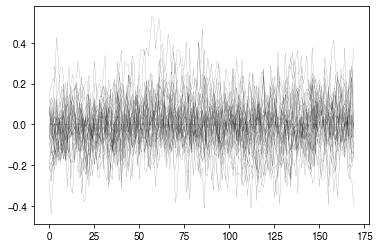

In [25]:
CMIP6_int_var_samples_nondeg.plot(legend=None,lw=0.1,c='k')

In [20]:
ant_coefs_iv = np.empty((CMIP6_int_var_samples_nondeg.columns.size,temp_ant.shape[1]))
nat_coefs_iv = np.empty((CMIP6_int_var_samples_nondeg.columns.size,temp_nat.shape[1]))

for i in tqdm.tqdm(np.arange(ant_coefs_iv.shape[1])):
    _lreg_coefs = OLSE_NORM(np.array([temp_ant.iloc[100:,i].values,temp_nat.iloc[100:,i].values]).T,CMIP6_int_var_samples_nondeg.values)['coefs']
    ant_coefs_iv[:,i] = _lreg_coefs[0]
    nat_coefs_iv[:,i] = _lreg_coefs[1]
#     ant_coefs_iv.iloc[:,i] = _lreg_coefs[0]
#     nat_coefs_iv.iloc[:,i] = _lreg_coefs[1]

100%|██████████| 180000/180000 [04:08<00:00, 723.50it/s]


In [21]:
chosen_year = 2014

## computing the present day value:
temp_attr_ant = pd.DataFrame(ant_coefs * (temp_ant.loc[chosen_year]-temp_ant.loc[baseline[0]:baseline[1]].mean()).values[np.newaxis,:],index=np.arange(100),columns=temp_ant.columns).unstack()
temp_attr_nat = pd.DataFrame(nat_coefs * (temp_nat.loc[chosen_year]-temp_nat.loc[baseline[0]:baseline[1]].mean()).values[np.newaxis,:],index=np.arange(100),columns=temp_ant.columns).unstack()

## computing the present day (2015-2019) rate:
temp_rate_attr_ant = pd.DataFrame(ant_coefs * OLSE_NORM(np.arange(5)[:,np.newaxis],temp_ant.loc[np.arange(chosen_year-4,chosen_year+1)].values)['coefs'],index=np.arange(100),columns=temp_ant.columns).unstack()
temp_rate_attr_nat = pd.DataFrame(nat_coefs * OLSE_NORM(np.arange(5)[:,np.newaxis],temp_nat.loc[np.arange(chosen_year-4,chosen_year+1)].values)['coefs'],index=np.arange(100),columns=temp_ant.columns).unstack()

## computing the present day value uncertainty from internal variability:
temp_attr_ant_iv = pd.DataFrame(ant_coefs_iv * (temp_ant.loc[chosen_year]-temp_ant.loc[baseline[0]:baseline[1]].mean()).values[np.newaxis,:],index=np.arange(CMIP6_int_var_samples_nondeg.columns.size),columns=temp_ant.columns).unstack()
temp_attr_nat_iv = pd.DataFrame(nat_coefs_iv * (temp_nat.loc[chosen_year]-temp_nat.loc[baseline[0]:baseline[1]].mean()).values[np.newaxis,:],index=np.arange(CMIP6_int_var_samples_nondeg.columns.size),columns=temp_ant.columns).unstack()

## computing the present day (2015-2019) rate uncertainty from internal variability:
temp_rate_attr_ant_iv = pd.DataFrame(ant_coefs_iv * OLSE_NORM(np.arange(5)[:,np.newaxis],temp_ant.loc[np.arange(chosen_year-4,chosen_year+1)].values)['coefs'],index=CMIP6_int_var_samples_nondeg.columns,columns=temp_ant.columns).unstack()
temp_rate_attr_nat_iv = pd.DataFrame(nat_coefs_iv * OLSE_NORM(np.arange(5)[:,np.newaxis],temp_nat.loc[np.arange(chosen_year-4,chosen_year+1)].values)['coefs'],index=CMIP6_int_var_samples_nondeg.columns,columns=temp_ant.columns).unstack()

In [22]:
## combine the sources of uncertainty:

temp_attr_ant_and_iv = (temp_attr_ant.unstack(level=2).values.reshape(N,18,-1,1) + temp_attr_ant_iv.unstack(level=2).values.reshape(N,18,1,-1)).astype(np.float32)
temp_attr_nat_and_iv = (temp_attr_nat.unstack(level=2).values.reshape(N,18,-1,1) + temp_attr_nat_iv.unstack(level=2).values.reshape(N,18,1,-1)).astype(np.float32)

temp_rate_attr_ant_and_iv = (temp_rate_attr_ant.unstack(level=2).values.reshape(N,18,-1,1) + temp_rate_attr_ant_iv.unstack(level=2).values.reshape(N,18,1,-1)).astype(np.float32)
temp_rate_attr_nat_and_iv = (temp_rate_attr_nat.unstack(level=2).values.reshape(N,18,-1,1) + temp_rate_attr_nat_iv.unstack(level=2).values.reshape(N,18,1,-1)).astype(np.float32)

In [23]:
# print('Anthro Temp statistics')
# print(temp_attr_ant.describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T)

# print('\nAnthro Temp rate statistics')
# print(temp_rate_attr_ant.describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T)

# print('\nTotal Temp statistics')
# print((temp_attr_ant+temp_attr_nat).describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T)

# print('\nTotal Temp rate statistics')
# print((temp_rate_attr_ant+temp_rate_attr_nat).describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T)

HIGH_constrain_level,LOW_constrain_level = np.quantile(temp_attr_ant_and_iv+temp_attr_nat_and_iv,[0.95,0.05])
HIGH_constrain_rate,LOW_constrain_rate = np.quantile(temp_rate_attr_ant_and_iv+temp_rate_attr_nat_and_iv,[0.95,0.05])

print('Temp level constraint:')
print(np.quantile(temp_attr_ant_and_iv+temp_attr_nat_and_iv,[0.05,0.5,0.95]))

print('\nTemp rate constraint:')
print(np.quantile(temp_rate_attr_ant_and_iv+temp_rate_attr_nat_and_iv,[0.05,0.5,0.95]))

Temp level constraint:
[0.434066   1.04325104 1.22645354]

Temp rate constraint:
[0.01660865 0.02747066 0.04008428]


Text(0, 0.5, 'rate of temperature change over 2015-2019 / K decade$^{-1}$')

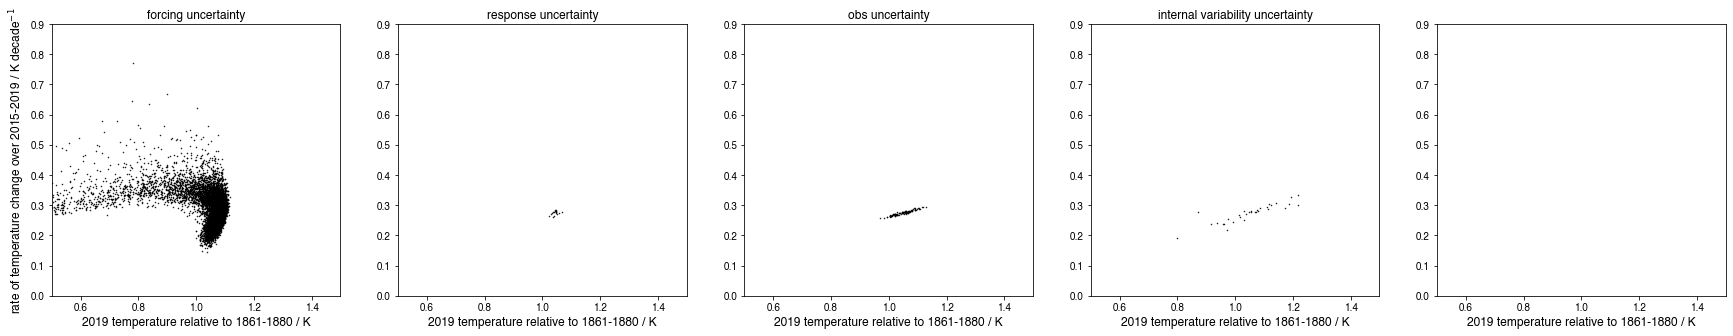

In [24]:
fig,ax=plt.subplots(1,5,figsize=(30,5))
# ax[0].hist2d((temp_attr_ant_and_iv+temp_attr_nat_and_iv).flatten(),10*(temp_rate_attr_ant_and_iv+temp_rate_attr_nat_and_iv).flatten(),bins=500,cmap='binary',density=True)

for i,source in enumerate(['forcing','response','obs','internal variability']):
    ax[i].scatter(np.median(temp_attr_ant_and_iv+temp_attr_nat_and_iv,axis=(np.arange(1,4)+i)%4),10*np.median(temp_rate_attr_ant_and_iv+temp_rate_attr_nat_and_iv,axis=(np.arange(1,4)+i)%4),color='k',marker='.',s=1)
    ax[i].set_title(source+' uncertainty')
    
[a.set_xlim(0.5,1.5) for a in ax]
[a.set_ylim(0.0,0.9) for a in ax]
[a.set_xlabel('2019 temperature relative to 1861-1880 / K',fontsize=12) for a in ax]
ax[0].set_ylabel('rate of temperature change over 2015-2019 / K decade$^{-1}$',fontsize=12)
# ax[0].set_title('FULL uncertainty',fontsize=12)

## Part II: constraining a large parameter ensemble

#### Forcing parameter uncertainties
We construct ensembles of the ERF parameters used in the model by scaling each default ERF parameter by a scaling factor sampled from the appropriate distribution:
- CO$_2$ ~ $\mathcal{N}\left(1,\frac{0.2}{\Phi^{-1}(0.95)}\right)$
- CH$_4$ ~ $\mathcal{N}\left(1,\frac{0.28}{\Phi^{-1}(0.95)}\right)$
- N$_2$O ~ $\mathcal{N}\left(1,\frac{0.2}{\Phi^{-1}(0.95)}\right)$
- other WMGHGs ~ $\mathcal{N}\left(1,\frac{0.2}{\Phi^{-1}(0.95)}\right)$
- tropospheric O$_3$ ~ $\mathcal{N}\left(1,\frac{0.5}{\Phi^{-1}(0.95)}\right)$
- stratospheric O$_3$ ~ $\mathcal{N}\left(1,\frac{2}{\Phi^{-1}(0.95)}\right)$
- stratospheric H$_2$O from CH$_4$ ~ $\mathcal{N}\left(1,\frac{0.72}{\Phi^{-1}(0.95)}\right)$
- BC on snow ~ lognormal with quantiles 0.05 = 0.5 and 0.95 = 2.25
- contrails ~ $\mathcal{N}\left(1,\frac{0.75}{\Phi^{-1}(0.95)}\right)$
- ERFari ~ $\alpha$ parameters drawn from CMIP6 inferred multivariate normal; resulting distribution scaled to match process based assessment in Bellouin (2020)
- ERFaci ~ parameters drawn independently from CMIP6 inferred distribution; resulting distribtuion scaled to match process based assessment Bellouin (2020)
- LUC ~ $\mathcal{N}\left(1,\frac{0.75}{\Phi^{-1}(0.95)}\right)$
- volcanic ~ $\mathcal{N}\left(1,\frac{0.5}{\Phi^{-1}(0.95)}\right)$
- solar ~ $\mathcal{N}\left(1,\frac{1}{\Phi^{-1}(0.95)}\right)$

N.B. the numerator in each normal distribution scale parameter gives the half the 90% confidence interval (ie. uncertainty in CO$_2$ ERF is $\pm20\%$).

In [2]:
## create parameter ensemble

### do we go for sampling gaussian forcings / non-gaussian forcings / carbon-cycle parameters / response parameters independently
### and assuming all uncertainties within these categories are correlated?

default_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',skiprows=1,index_col=0)
forcing_namelist = list(default_params.columns)

In [3]:
print(forcing_namelist)

['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|strat_o3', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'halon2402|strat_o3', 'hcfc141b|strat_o3', 'hcfc142b|strat_o3', 'hcfc22|strat_o

In [4]:
param_categories = pd.Series(index = forcing_namelist,dtype=object)
param_categories.loc[['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8','carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methyl_bromide', 'methyl_chloride', 'nf3', 'sf6', 'so2f2', 'halon1202']] = 'other_wmghgs'
param_categories.loc['carbon_dioxide'] = 'carbon_dioxide'
param_categories.loc['methane'] = 'methane'
param_categories.loc['nitrous_oxide'] = 'nitrous_oxide'
param_categories.loc[[x for x in forcing_namelist if '|trop_o3' in x]] = 'trop_o3'
param_categories.loc[[x for x in forcing_namelist if '|strat_o3' in x]] = 'strat_o3'
param_categories.loc[[x for x in forcing_namelist if '|strat_h2o' in x]] = 'strat_h2o'
param_categories.loc[['so2', 'nox', 'co', 'nmvoc', 'bc', 'nh3','oc','nox_avi']] ='ari'
param_categories.loc[['so2|aci','oc|aci','bc|aci']] = 'aci'
param_categories.loc['bc|bc_on_snow'] ='bc_on_snow'
param_categories.loc['nox_avi|contrails'] = 'contrails'

In [5]:
category_distributions = pd.Series(index = param_categories.unique(),dtype=object)

category_distributions.loc['carbon_dioxide'] = sp.stats.norm(1,0.20/1.645)

category_distributions.loc['methane'] = sp.stats.norm(1,0.28/1.645)

category_distributions.loc['nitrous_oxide'] = sp.stats.norm(1,0.2/1.645)

category_distributions.loc['other_wmghgs'] = sp.stats.norm(1,0.20/1.645)

category_distributions.loc['trop_o3'] = sp.stats.norm(1,0.5/1.645)

category_distributions.loc['strat_o3'] = sp.stats.norm(1,2/1.645)

category_distributions.loc['strat_h2o'] = sp.stats.norm(1,0.72/1.645)

pct_5 = 0.04 / 0.08 # need to scale by the mean to turn into a "scaling factor"
pct_95=0.18 / 0.08
sigma = (np.log(pct_95) - np.log(pct_5)) / (sp.stats.norm().ppf(0.95)-sp.stats.norm().ppf(0.05))
mu = np.log(pct_5) - sigma * sp.stats.norm().ppf(0.05)
category_distributions.loc['bc_on_snow'] = sp.stats.lognorm(s=sigma,scale=np.exp(mu))

category_distributions.loc['contrails'] = sp.stats.norm(1,0.75/1.645)

## experimental: assume aerosol uncertainty is normal:

category_distributions.loc['ari'] = sp.stats.norm(1,1/1.645)
category_distributions.loc['aci'] = sp.stats.norm(1,0.3)

# def fit_aerosol_distribution(x,distr,pct,z):
#     return np.sum(abs(distr.cdf(z,*x) - pct))
# category_distributions.loc['aerosols'] = sp.stats.genlogistic(*sp.optimize.minimize(fit_aerosol_distribution,x0=np.array([0.5,1,1]),args=(sp.stats.genlogistic,np.array([0.05,0.5,0.95]),np.array([0.11,1,2.11])),method='nelder-mead').x)

In [6]:
## draw large ensembles of these distributions

N = 10000

parameter_ensemble_draw = pd.DataFrame(index = category_distributions.index , columns = ['mem'+str(x) for x in np.arange(N)])

for driver in parameter_ensemble_draw.index:
    parameter_ensemble_draw.loc[driver,:] = category_distributions.loc[driver].rvs(N)

In [7]:
# map the forcing driver categories onto the agents:
forcing_category_map = np.array([(parameter_ensemble_draw.index==param_categories.loc[x]).argmax() for x in forcing_namelist])

In [8]:
gas_parameter_ensemble = pd.concat([default_params.copy()]*N,axis=1,keys=parameter_ensemble_draw.columns)

gas_parameter_ensemble.loc['f1':'f3',:] = gas_parameter_ensemble.loc['f1':'f3',:]*parameter_ensemble_draw.values[forcing_category_map].T.reshape(1,-1)

#### Carbon cycle parameter uncertainties

In [9]:
## draw large ensemble of carbon cycle parameters based on the assessed range in Millar (2017):

cc_param_draw = sp.stats.norm(1,0.13/1.645).rvs(N).reshape(1,-1)

In [10]:
gas_parameter_ensemble.loc['r0':'rT',(slice(None),'carbon_dioxide')] = gas_parameter_ensemble.loc['r0':'rT',(slice(None),'carbon_dioxide')].values * cc_param_draw

#### Response parameter uncertainties

In [11]:
## draw ln d1, d2, q1 | RWF , d3 | TCR

# covariance of ln_d1, d2, q1
cov_mat_1 = np.array([[2.94358445e-01, 5.58963469e-01, 3.49480987e-02],
       [5.58963469e-01, 7.05140407e+00, 1.26045312e-01],
       [3.49480987e-02, 1.26045312e-01, 6.51046487e-03]])

mean_mat_1 = np.array([-0.08642002,  8.16552935,  0.20359601])

# covariance of RWF, d3
cov_mat_2 = np.array([[ 1.44088893e-02, -6.69645898e+00],
       [-6.69645898e+00,  6.34183337e+03]])

mean_mat_2 = np.array([  0.54430983, 261.86477998])

F_2x = gas_parameter_ensemble.loc['f1',(slice(None),'carbon_dioxide')].values * np.log(2) + gas_parameter_ensemble.loc['f3',(slice(None),'carbon_dioxide')].values * (np.sqrt(278*2) - np.sqrt(278))

lnd1 , d2 , q1 , RWF , d3 , TCR , d1 , ECS , v1 , v2 , v3 , q2 , q3 = np.empty((13,N))

neg_idx = np.ones(N).astype(bool)
N_neg = neg_idx.sum()

while N_neg>0:

    lnd1[neg_idx], d2[neg_idx], q1[neg_idx] = sp.stats.multivariate_normal(mean_mat_1,cov_mat_1).rvs(N_neg).T
    RWF[neg_idx], d3[neg_idx] = sp.stats.multivariate_normal(mean_mat_2,cov_mat_2).rvs(N_neg).T
    TCR[neg_idx] = sp.stats.truncnorm(-2,2,1.85, 0.75).rvs(N_neg)
    d1[neg_idx] = np.exp(lnd1[neg_idx])
    ECS[neg_idx] = TCR[neg_idx]/RWF[neg_idx]

    v1[neg_idx] = (1-(d1/69.66) * (1-np.exp(-69.66/d1)) )[neg_idx]
    v2[neg_idx] = (1-(d2/69.66) * (1-np.exp(-69.66/d2)) )[neg_idx]
    v3[neg_idx] = (1-(d3/69.66) * (1-np.exp(-69.66/d3)) )[neg_idx]

    q3[neg_idx] = (((TCR/F_2x) - q1*(v1-v2) - (ECS/F_2x)*v2) / (v3-v2))[neg_idx]
    q2[neg_idx] = (ECS/F_2x - q1 -  q3)[neg_idx]
    
    neg_idx = np.any(np.array([d1,d2,d3,q1,q2,q3])<0,axis=0)
    N_neg = neg_idx.sum()
    
response_par_ensemble = np.array([d1,d2,d3,q1,q2,q3]).T
thermal_parameter_ensemble = pd.concat([get_thermal_parameter_defaults()['default'].copy()]*N,axis=1,keys=['mem'+str(x) for x in np.arange(N)])
thermal_parameter_ensemble.loc[:] = response_par_ensemble.reshape(N,2,3).swapaxes(0,1).reshape(2,-1)

In [12]:
# ## creating the thermal parameter response

# ### Key point: with three parameters it is very easy to force one to go negative: so we draw parameters from a multivariate normal inferred from the CMIP6 ensemble

# ## draw d1 lognormally, others normally + truncate at 3-sigma

# response_par_cov = np.array([[ 2.94358445e-01,  5.58963469e-01,  1.29338443e+01,
#          3.49480987e-02, -2.77113736e-02,  3.50228561e-02],
#        [ 5.58963469e-01,  7.05140407e+00,  5.23675036e+01,
#          1.26045312e-01,  2.19537680e-01,  2.91806222e-01],
#        [ 1.29338443e+01,  5.23675036e+01,  6.34183337e+03,
#          1.43715561e+00,  2.96970497e+00,  1.22502826e+01],
#        [ 3.49480987e-02,  1.26045312e-01,  1.43715561e+00,
#          6.51046487e-03, -4.15900581e-03,  2.58438391e-03],
#        [-2.77113736e-02,  2.19537680e-01,  2.96970497e+00,
#         -4.15900581e-03,  2.75795314e-02,  2.28847040e-02],
#        [ 3.50228561e-02,  2.91806222e-01,  1.22502826e+01,
#          2.58438391e-03,  2.28847040e-02,  7.52248663e-02]])

# response_par_mean = np.array([-8.64200190e-02,  8.16552935e+00,  2.61864780e+02,  2.03596012e-01,
#         3.98107002e-01,  5.45638414e-01])

# response_par_ensemble = sp.stats.multivariate_normal(response_par_mean,response_par_cov).rvs(2*N)

# # transform d1 back
# response_par_ensemble[...,0] = np.exp(response_par_ensemble[...,0])

# # We then truncate the other parameters at the 3-sigma range (this forces all parameters to be +ve)
# response_par_ensemble = response_par_ensemble[np.all((response_par_ensemble[...,1:]>np.quantile(response_par_ensemble[...,1:],0.025,axis=0))&(response_par_ensemble[...,1:]<np.quantile(response_par_ensemble[...,1:],0.975,axis=0)),axis=1)]

# random_indices = np.random.choice(np.arange(response_par_ensemble.shape[0]),N,replace=False)

# response_par_ensemble = response_par_ensemble[random_indices]

# thermal_parameter_ensemble = pd.concat([get_thermal_parameter_defaults()['default'].copy()]*N,axis=1,keys=['mem'+str(x) for x in np.arange(N)])

# thermal_parameter_ensemble.loc[:] = response_par_ensemble.reshape(N,2,3).swapaxes(0,1).reshape(2,-1)

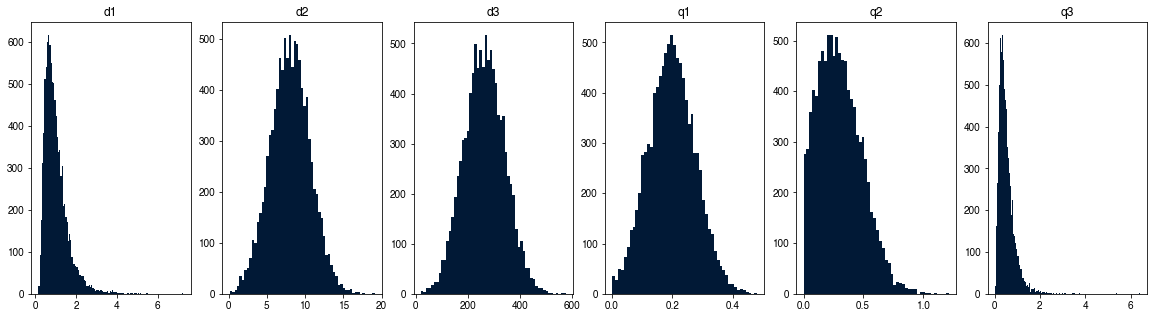

In [13]:
fig,ax = plt.subplots(1,6,figsize=(20,5))
hists = [ax[i].hist(response_par_ensemble[...,i]) for i in np.arange(6)]
titles = [ax[i].set_title(['d1','d2','d3','q1','q2','q3'][i]) for i in np.arange(6)]

#### Model run with RCMIP emissions

In [14]:
scenarios = ['ssp'+x for x in ['119','126','245','370','370-lowNTCF-aerchemmip','370-lowNTCF-gidden','434','460','534-over','585']]
ssp_emms = pd.concat([RCMIP_to_GIR_input_emms(x) for x in scenarios],keys=['esm-'+x+'-allGHG' for x in scenarios],axis=1).interpolate()
ssp_emms -= ssp_emms.loc[1750] # emissions relative to 1750 values
ssp_forc = pd.concat([get_RCMIP_forc(x) for x in scenarios],keys=['esm-'+x+'-allGHG' for x in scenarios],axis=1).interpolate()
ssp_forc -= ssp_forc.loc[1750]

In [15]:
## let's run the ensembles!!

FULL = run_GIR(emissions_in=ssp_emms.reindex(['esm-ssp245-allGHG'],axis=1,level=0).reindex(np.arange(1750,2101)),forcing_in=ssp_forc.reindex(['esm-ssp245-allGHG'],axis=1,level=0).reindex(np.arange(1750,2101)),gas_parameters=gas_parameter_ensemble,thermal_parameters=thermal_parameter_ensemble)

Integrating 1 scenarios, 10000 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['bc', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc11', 'cfc113', 'cfc114', 'cfc115', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'co', 'halon1202', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nh3', 'nitrous_oxide', 'nmvoc', 'nox', 'nox_avi', 'oc', 'sf6', 'so2', 'so2f2'], between 1750 and 2100...


100%|██████████| 350/350 [00:24<00:00, 14.15 timestep/s]


#### Constrain and compare prior / posterior distributions

In [40]:
temp_constraint = ((FULL['T'].loc[chosen_year]-FULL['T'].loc[baseline[0]:baseline[1]].mean())<HIGH_constrain_level)&((FULL['T'].loc[chosen_year]-FULL['T'].loc[baseline[0]:baseline[1]].mean())>LOW_constrain_level)
rate_constraint = (FULL['T'].diff(5).loc[chosen_year]/5<HIGH_constrain_rate)&(FULL['T'].diff(5).loc[chosen_year]/5>LOW_constrain_rate)

/home/leachl/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3263: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leachl/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3263: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  """
/home/leachl/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3263: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await sel

(1750.0, 2100.0)

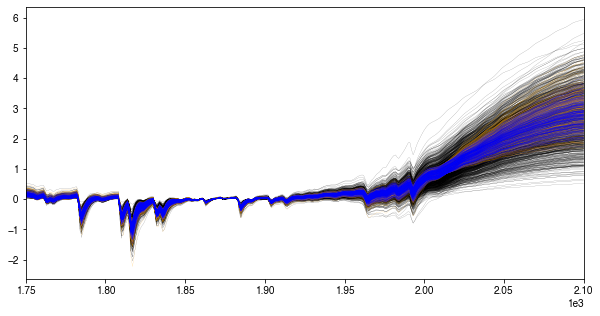

In [41]:
fig,ax = plt.subplots(figsize=(10,5))

(FULL['T']-FULL['T'].loc[1861:1880].mean()).iloc[:,np.random.choice(N,1000)].plot(ax=ax,lw=0.1,c='k',legend=None)

(FULL['T']-FULL['T'].loc[1861:1880].mean()).loc[:,temp_constraint].iloc[:,np.random.choice(temp_constraint.sum(),temp_constraint.sum()//10)].plot(ax=ax,lw=0.1,c='orange',legend=None)

# (FULL['T']-FULL['T'].loc[1861:1880].mean()).loc[:,rate_constraint].plot(ax=ax,lw=0.1,c='r',legend=None)

(FULL['T']-FULL['T'].loc[1861:1880].mean()).loc[:,temp_constraint&rate_constraint].iloc[:,np.random.choice((temp_constraint&rate_constraint).sum(),(temp_constraint&rate_constraint).sum()//10)].plot(ax=ax,lw=0.1,c='b',legend=None)

plt.xlim(1750,2100)

In [42]:
constrained_tcr_ecs = pd.DataFrame(index=['ECS','TCR'],columns=FULL['T'].columns.levels[1])

for mem in constrained_tcr_ecs.columns:
    f = gas_parameter_ensemble.loc['f1':'f3',(mem,'carbon_dioxide')].values
    constrained_tcr_ecs.loc[:,mem] = q_to_tcr_ecs(thermal_parameter_ensemble.reindex([mem],axis=1,level=0),F_2x=f[0]*np.log(2)+f[2]*(np.sqrt(278*2)-np.sqrt(278))).values.flatten()

In [43]:
constrained_tcr_ecs.loc['T_2100'] = (FULL['T']-FULL['T'].loc[1861:1880].mean()).loc[2100].loc['esm-ssp245-allGHG']
constrained_tcr_ecs.loc['ari_rf_2019'] = FULL['RF'].loc[2019,(slice(None),slice(None),[x for x in FULL['RF'].columns.levels[-1] if x in ['so2','nox','co','nmvoc','bc','nh3','oc',]])].groupby(level=[0,1]).sum().loc['esm-ssp245-allGHG']
constrained_tcr_ecs.loc['aci_rf_2019'] = FULL['RF'].loc[2019,(slice(None),slice(None),[x for x in FULL['RF'].columns.levels[-1] if x in ['so2|aci','bc|aci','oc|aci',]])].groupby(level=[0,1]).sum().loc['esm-ssp245-allGHG']
constrained_tcr_ecs.loc['aer_rf_2019'] = constrained_tcr_ecs.loc['aci_rf_2019']+constrained_tcr_ecs.loc['ari_rf_2019']
constrained_tcr_ecs.loc['constrain'] = (rate_constraint&temp_constraint).droplevel(0)

In [44]:
print(forcing_namelist)

['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|strat_o3', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'halon2402|strat_o3', 'hcfc141b|strat_o3', 'hcfc142b|strat_o3', 'hcfc22|strat_o3', 'methyl_bromide|strat_o3', '

In [45]:
## add in some more degrees of freedom:
ghg_list = ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202','carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'halon2402|strat_o3', 'hcfc141b|strat_o3', 'hcfc142b|strat_o3', 'hcfc22|strat_o3', 'methyl_bromide|strat_o3', 'methyl_chloride|strat_o3', 'halon1202|strat_o3','methane|strat_o3', 'methane|trop_o3', 'methane|strat_h2o','co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3']
constrained_tcr_ecs.loc['ghg_rf_2019'] = FULL['RF'].loc[2019,(slice(None),slice(None),[x for x in FULL['RF'].columns.levels[-1] if x in ghg_list])].groupby(level=[0,1]).sum().loc['esm-ssp245-allGHG']
constrained_tcr_ecs.loc['co2_rf_2019'] = FULL['RF'].loc[2019,(slice(None),slice(None),'carbon_dioxide')].droplevel([0,2])

In [46]:
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

def custom_kde(x,y,**kws):
    ax = plt.gca()
    gridsize=200
    k = sp.stats.kde.gaussian_kde([x,y])
    xi,yi = np.mgrid[x.min()-0.5:x.max()+0.5:gridsize*1j,y.min()-0.5:y.max()+0.5:gridsize*1j]
    zi = k(np.vstack([xi.flatten(),yi.flatten()])).reshape(xi.shape)
    dens_vals = np.linspace(0,zi.max(),gridsize)
    zi_int = ((zi>=dens_vals[:,None,None])*zi).sum(axis=(1,2))/zi.sum()
    zi_int_to_dens = sp.interpolate.interp1d(zi_int,dens_vals)
    dens_contours = zi_int_to_dens([0.95,0.67,0.33,0.05])
    kdeplot = ax.contour(xi,yi,zi,dens_contours,colors=kws['color'])
    return ax

def custom_kde_constrain(x,y,**kws):
    ax = plt.gca()
    if kws['label']==1:
        gridsize=200
        k = sp.stats.kde.gaussian_kde([x,y])
        xi,yi = np.mgrid[x.min()-0.5:x.max()+0.5:gridsize*1j,y.min()-0.5:y.max()+0.5:gridsize*1j]
        zi = k(np.vstack([xi.flatten(),yi.flatten()])).reshape(xi.shape)
        dens_vals = np.linspace(0,zi.max(),gridsize)
        zi_int = ((zi>=dens_vals[:,None,None])*zi).sum(axis=(1,2))/zi.sum()
        zi_int_to_dens = sp.interpolate.interp1d(zi_int,dens_vals)
        dens_contours = zi_int_to_dens([0.95,0.67,0.33,0.05])
        kdeplot = ax.contour(xi,yi,zi,dens_contours,colors=kws['color'])
    return ax

def custom_scatter(x,y,**kws):
    ax = plt.gca()
    if kws['label']==1:
        ax.scatter(x,y,c=constrained_tcr_ecs.loc['aer_rf_2019',constrained_tcr_ecs.loc['constrain'].astype(bool)],cmap=cmocean.cm.curl.reversed(),s=3,zorder=0)
    else:
        ax.scatter(x,y,c='grey',s=0.5,zorder=0)
    return ax

def custom_scatter_plain(x,y,**kws):
    ax = plt.gca()
    if kws['label']==1:
        ax.scatter(x,y,c='k',s=0.1,zorder=1)
    else:
        ax.scatter(x,y,c='grey',s=0.01,zorder=0)
    return ax

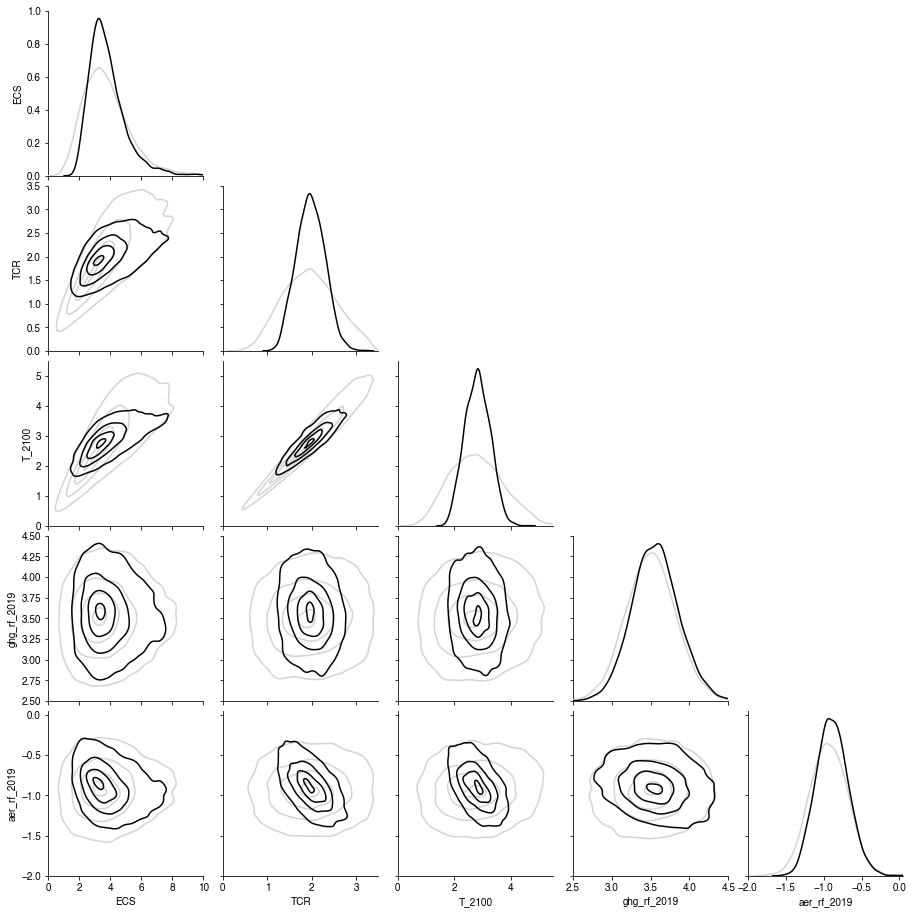

In [47]:
g = sn.PairGrid(constrained_tcr_ecs.T,vars=['ECS','TCR','T_2100','ghg_rf_2019','aer_rf_2019'],diag_sharey=False)

g.map_upper(hide_current_axis)

g.map_diag(sn.distplot,hist=False,color='lightgrey')
g.map_lower(custom_kde,color='lightgrey')

g._hue_var = 'constrain'
g.hue_vals = constrained_tcr_ecs.T["constrain"]
g.hue_names = [1,0]
g.palette = [(0,0,0),(1,1,1,0)]

g.map_diag(sn.distplot,hist=False)
g.map_lower(custom_kde_constrain,color='k')

limits = [[0,10],[0,3.5],[0,5.5],[2.5,4.5],[-2,0.05]]

for i in np.arange(5):
    for j in np.arange(5):
        g.axes[i,j].set_xlim(*limits[j])
        if i!=0:
            g.axes[i,j].set_ylim(*limits[i])

In [48]:
constrained_tcr_ecs.loc[:,constrained_tcr_ecs.loc['constrain'].astype(bool)].T.describe(percentiles=[.05,.16,.33,.5,.66,.84,.95])

,ECS,TCR,T_2100,ari_rf_2019,aci_rf_2019,aer_rf_2019,constrain,ghg_rf_2019,co2_rf_2019
count,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000,3179.0,3179.000000,3179.000000
mean,3.817081,1.974155,2.817155,-0.147873,-0.739040,-0.886913,1.0,3.562319,1.961311
std,1.213382,0.313417,0.437868,0.089292,0.204493,0.210323,0.0,0.297104,0.242688
min,1.662996,1.101074,1.658579,-0.475696,-1.405289,-1.539593,1.0,2.621686,1.089626
5%,2.326962,1.454925,2.096755,-0.294809,-1.060547,-1.223000,1.0,3.082541,1.568073
16%,2.759652,1.653473,2.367258,-0.235358,-0.941276,-1.097215,1.0,3.271881,1.718744
33%,3.187714,1.827677,2.611529,-0.188119,-0.837388,-0.981924,1.0,3.426120,1.851988
50%,3.575471,1.968551,2.815247,-0.148317,-0.744731,-0.890940,1.0,3.557696,1.959383
66%,4.028298,2.107806,2.998131,-0.111446,-0.658400,-0.805093,1.0,3.674908,2.060078
84%,4.802920,2.292620,3.276760,-0.059538,-0.533914,-0.680938,1.0,3.853329,2.197521


In [49]:
constrained_tcr_ecs.T.describe(percentiles=[.05,.16,.33,.5,.66,.84,.95])

,ECS,TCR,T_2100,ari_rf_2019,aci_rf_2019,aer_rf_2019,constrain,ghg_rf_2019,co2_rf_2019
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.789246,1.956010,2.795279,-0.157846,-0.775105,-0.932951,0.317900,3.505167,1.928976
std,1.604763,0.591939,0.928310,0.094733,0.232106,0.248684,0.465684,0.318864,0.254887
min,0.611826,0.400587,0.493961,-0.487343,-1.623392,-1.799582,0.000000,2.195327,0.819258
5%,1.730207,1.005835,1.361639,-0.314651,-1.156304,-1.337038,0.000000,2.986608,1.518362
16%,2.327130,1.333916,1.829281,-0.250272,-1.008451,-1.183769,0.000000,3.187409,1.676476
33%,2.985479,1.666062,2.329683,-0.198997,-0.877475,-1.043911,0.000000,3.364137,1.814173
50%,3.556274,1.941842,2.756646,-0.158677,-0.775505,-0.935485,0.000000,3.505254,1.925829
66%,4.159312,2.204451,3.163156,-0.119568,-0.677517,-0.828871,0.000000,3.633962,2.033226
84%,5.157216,2.580463,3.756813,-0.063142,-0.541009,-0.685630,1.000000,3.818337,2.179669


## Supplementary Figures